In [268]:
import pathlib
import pylab as plt

import os
import re
import itertools  
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib
import seaborn as sns
import sys
#print(sys.executable.split('miniconda3/envs/')[1])

In [269]:
sns.set_style('white')

In [270]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [271]:
PRJ='PRJNA901878'
BASE_PATH='/mnt/8TB_0/Data/genbank/'
DATA_PATH=f'{BASE_PATH}{PRJ}/'
PLOT_PATH=f'/mnt/8TB_2/Data/Assembly/{PRJ}/general_plots/'
PLOT_DATA_FILE='Runs.csv'
DATA_EXT='_ncbi_mt_minimap2_coverage.txt'
TAXA = '/mnt/1TB_0/Data/fasta/mitochondria/ncbi_mt_20220505.taxa'
ITERATION=0
PARAMS='sr'
ABS_MIN_COV=10
COVERAGE=50

In [272]:
df_run=pd.read_csv(PLOT_PATH+PLOT_DATA_FILE)
host=df_run['HOST'].tolist()
host_summs=[]
for h in host:
    name=h.split()
    if len(name)==1:
        host_summ=h[:5]
    elif len(name)==2:
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
    else:  
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ_3=name[2]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
        host_summ=host_summ+' '+host_summ_3[:2]
    host_summs.append(host_summ)
df_run['host_summ']=host_summs
df_run.shape

(466, 18)

In [273]:
def read_taxa():
    f = open(TAXA,"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    for line in lines:
        asc=line.split()[0]
        descr=line.split(None,1)[1]
        descr=descr.rstrip()
        ascs.append(asc)
        descrs.append(descr)
    return ascs, descrs

In [274]:
def match_runs(sras, df_run):
    run_name=df_run['Sample Name'].tolist()
    run_SRA=df_run['Run'].tolist()
    run_host=df_run['HOST'].tolist()
    run_host_summ=df_run['host_summ'].tolist()
    print(f'run name: {run_name[:2]} {len(run_name)}')
    print(f'run_SRA: {run_SRA[:2]} {len(run_SRA)}')
    print(f'run_host: {run_host[:2]} {len(run_host)}')
    print(f'run_host_summ: {run_host_summ[:2]} {len(run_host_summ)}')
    host_summs=[]
    names=[]
    hosts=[]
    n=0
    for sra in sras:
        if (n % 100==0):
            print(sra)
            print(run_SRA.index(sra.strip()))
        idx=run_SRA.index(sra.strip())
        name=run_name[idx]
        host=run_host[idx]
        host_summ=run_host_summ[idx]
        names.append(name)
        hosts.append(host)
        host_summs.append(host_summ)
        n+=1
    return names, hosts, host_summs

In [275]:
def match_ascession(ascessions, taxa_asc, taxa_descr):
    descrs=[]
    for asc in ascessions:
        try:
            idx=taxa_asc.index(asc.strip())
            descr=taxa_descr[idx]
            descrs.append(descr)
        except ValueError as e:
            print(f'Error with: {asc}')
            t=!blastdbcmd -db nt -entry asc.strip()
            print(f'{t}')
            if 'Entry not found:' in t[0]:
                descrs.append('Entry not found:')
                print(f'Entry not found: {asc}')
            else:
                descr=t[0].split(' ', 1)[1]
                descrs.append(descr)
    return descrs

In [276]:
def get_num_reads(sra):
    f = open(DATA_PATH+sra+'_fastp.json',"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    hit=False
    reads=0
    for line in lines:
        if '"after_filtering":' in line:
            hit=True
        if '"total_reads":' in line:
            if hit:
                reads=line.split(':')[1]
                reads = re.sub('[^0-9]','', reads)
                reads=int(reads.split()[0])
                hit=False
    return reads

In [277]:
def parse_mt_files():
    #if coverage calculated on viral file not mt, then re-run coverage 
    all_files = os.listdir(DATA_PATH)
    coverage_files = [f for f in all_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    for f in coverage_files:
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            ascessions = df['#rname']
            if 'NC_045512.2' in ascessions.tolist():
                srr= f.split('_',1)[0]
                #print(df.head(n=2))
                print(f'running samtools coverage on {srr}')
                !samtools coverage {DATA_PATH}{srr}_ncbi_mt_minimap2_sorted.bam -o {DATA_PATH}{srr}_ncbi_mt_minimap2_coverage.txt
        except Exception as e:
            print(f'{f} {str(e)}')

In [278]:
def expand_fields(df_all):
    sras=df_all['SRA']
    sras=list(set(sras))
    names, hosts, host_summs = match_runs(sras, df_run)
    df_all['sample_name'] = names
    sample_name_species=list(map(" ".join, itertools.product(names, host_summs)))
    print(len(sample_name_species))
    print(sample_name_species[:10])
    print(len(hosts))
    #df_all['sample_name_species'] = sample_name_species
    #df_all['host'] = hosts
    return df_all

In [279]:
def read_coverage(df_run, taxa_asc, taxa_descr, truncate_at_min=True):
    all_files = os.listdir(DATA_PATH)
    coverage_files = [f for f in all_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    
    for f in coverage_files:
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            df = df.sort_values(by=['coverage'], ascending=False)
            if truncate_at_min:
                df = df[df['coverage'] >= ABS_MIN_COV]  
            ascessions = df['#rname']
            if 'NC_045512.2' in ascessions.tolist():
                #virus coverage in file, not mt, needs to be re-run using parse_mt_files()
                continue
            try:
                descrs=match_ascession(ascessions, taxa_asc, taxa_descr)
                df['description']=descrs
                srr= f.split('_',1)[0]
                #srr=srr.split('/')[-1]
                df['SRA']=[srr]*len(df)
                sample_name=df_run.loc[df_run['Run'] == srr, 'Sample Name'].tolist()[0]
                df['sample_name']=[sample_name]*len(df)
                #numreads
                df['total_reads']=get_num_reads(srr)*len(df)
                df['mt_reads']=df['numreads'].sum()
                df['pct_mt']=(df['numreads']/df['mt_reads'])*100
                #keep only highest mt coverage where have duplicates
                df=df.drop_duplicates(subset='sample_name', keep="first")
                frames.append(df)
            except KeyError as e:
                print(f'KeyError error with {f}')
                #print(df.head())
        except Exception as e:
            print(f'{str(e)} error with {f}')
    df_all=pd.concat(frames)
    return df_all

In [280]:
#parse_mt_files()

In [281]:
taxa_asc, taxa_descr = read_taxa()

### read/write section

In [282]:
df_all = read_coverage(df_run, taxa_asc, taxa_descr)

[Errno 2] No such file or directory: '/mnt/8TB_0/Data/genbank/PRJNA901878/SRR22936601_fastp.json' error with SRR22936601_ncbi_mt_minimap2_coverage.txt
No columns to parse from file error with SRR22936849_ncbi_mt_minimap2_coverage.txt


In [283]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
4513,NC_014770.1,1,17001,171025,17001,100.0000,1485.240,35.7,30.6,Panthera tigris,SRR22936859,FL6,2602646280,267834,63.854850
2580,NC_050263.1,1,16833,3241773,16833,100.0000,28587.400,36.1,59.2,Hystrix brachyura,SRR22936764,FL21,84046208,3241870,99.997008
3208,NC_010642.1,1,16990,98421,16988,99.9882,864.804,35.5,31.4,Panthera tigris,SRR22936863,FL2,3415421016,155302,63.373942
4123,NC_011029.1,1,17131,154047,16392,95.6862,1326.070,35.6,44.5,Ochotona curzoniae,SRR22936850,C3-30.2,1331234816,259321,59.403982
1929,NC_053269.1,1,16886,9958695,16886,100.0000,88122.900,35.9,59.6,Rhinolophus affinis,SRR22936806,L164.18,2001785220,9987535,99.711240


In [284]:
#df_all.to_csv(PLOT_PATH+'runs_preprocessed.csv', index=False)

In [285]:
df_all=pd.read_csv(PLOT_PATH+'runs_preprocessed.csv')

In [286]:
#df_all.drop(['Unnamed: 0'], axis=1, inplace=True)
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
0,NC_014770.1,1,17001,171025,17001,100.0000,1485.240,35.7,30.6,Panthera tigris,SRR22936859,FL6,2602646280,267834,63.854850
1,NC_050263.1,1,16833,3241773,16833,100.0000,28587.400,36.1,59.2,Hystrix brachyura,SRR22936764,FL21,84046208,3241870,99.997008
2,NC_010642.1,1,16990,98421,16988,99.9882,864.804,35.5,31.4,Panthera tigris,SRR22936863,FL2,3415421016,155302,63.373942
3,NC_011029.1,1,17131,154047,16392,95.6862,1326.070,35.6,44.5,Ochotona curzoniae,SRR22936850,C3-30.2,1331234816,259321,59.403982
4,NC_053269.1,1,16886,9958695,16886,100.0000,88122.900,35.9,59.6,Rhinolophus affinis,SRR22936806,L164.18,2001785220,9987535,99.711240


In [287]:
df_all.nunique()

#rname         38
startpos        1
endpos         36
numreads       86
covbases       68
coverage       55
meandepth      86
meanbaseq      13
meanmapq       71
description    37
SRA            86
sample_name    86
total_reads    86
mt_reads       86
pct_mt         85
dtype: int64

In [288]:
### filter to => n%
df_all = df_all.loc[df_all['coverage'] >=COVERAGE]

In [289]:
df_all.description=df_all.description.str.replace(' mitochondrion, complete genome', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete genome', '')

In [290]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,sample_name,total_reads,mt_reads,pct_mt
0,NC_014770.1,1,17001,171025,17001,100.0000,1485.240,35.7,30.6,Panthera tigris,SRR22936859,FL6,2602646280,267834,63.854850
1,NC_050263.1,1,16833,3241773,16833,100.0000,28587.400,36.1,59.2,Hystrix brachyura,SRR22936764,FL21,84046208,3241870,99.997008
2,NC_010642.1,1,16990,98421,16988,99.9882,864.804,35.5,31.4,Panthera tigris,SRR22936863,FL2,3415421016,155302,63.373942
3,NC_011029.1,1,17131,154047,16392,95.6862,1326.070,35.6,44.5,Ochotona curzoniae,SRR22936850,C3-30.2,1331234816,259321,59.403982
4,NC_053269.1,1,16886,9958695,16886,100.0000,88122.900,35.9,59.6,Rhinolophus affinis,SRR22936806,L164.18,2001785220,9987535,99.711240


In [291]:
df_pivot=df_all.pivot_table(index='sample_name', columns='description', values='coverage')

In [292]:
df_pivot.head()

description,Ailurus fulgens,Apodemus draco,Ardea modesta,Cercopithecus lhoesti,Dremomys pernyi,Erythrocebus patas,Felis silvestris,Hepatozoon catesbianae,Hipposideros armiger,Hipposideros larvatus,...,Rhinolophus rex,Rhinolophus thomasi,Rhinopithecus roxellana,Rhizomys pruinosus,Saimiri oerstedii,Sus scrofa,Tamiops swinhoei,Trachypithecus poliocephalus,Uropsilus soricipes,Viverra zibetha
sample_name,,,,,,,,,,,,,,,,,,,,,
C1-4.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
C1-9.18,NaN,93.5020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1-9.2,NaN,93.8337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3-13.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3-17.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


order_by=df_accessions['Accession'].tolist()
cols=df_pivot.columns.tolist()
reorder_cols=[]
for o in order_by:
    for c in cols:
        if o.strip()==c.strip(): 
            reorder_cols.append(c)
assert len(cols)==len(reorder_cols)

In [293]:
#df_pivot=df_pivot.reindex(columns= reorder_cols)

In [294]:
#df_pivot.columns

In [295]:
def get_samples(y_labels, df_datasets):
    y_names=[]
    for sra in y_labels:
        y_names.append(df_run.loc[df_run['SRA'] == sra.strip(), 'Sample Name'].values[0])
        y_hosts.append(df_run.loc[df_run['SRA'] == sra.strip(), 'HOST'].values[0])
    return y_names, y_hosts

In [296]:
def get_accessions(x_labels, df_accessions):
    x_codes=[]
    for accession in x_labels:
        x_codes.append(df_accessions.loc[df_accessions['Accession'] == accession.strip(), 'Code'].values[0])
    return x_codes

In [297]:
df_pivot_t=df_pivot.T
data=df_pivot_t.to_numpy()

y_labels=df_pivot_t.index.tolist()
x_labels=list(df_pivot_t.columns.values)

In [298]:
df_pivot.head()

description,Ailurus fulgens,Apodemus draco,Ardea modesta,Cercopithecus lhoesti,Dremomys pernyi,Erythrocebus patas,Felis silvestris,Hepatozoon catesbianae,Hipposideros armiger,Hipposideros larvatus,...,Rhinolophus rex,Rhinolophus thomasi,Rhinopithecus roxellana,Rhizomys pruinosus,Saimiri oerstedii,Sus scrofa,Tamiops swinhoei,Trachypithecus poliocephalus,Uropsilus soricipes,Viverra zibetha
sample_name,,,,,,,,,,,,,,,,,,,,,
C1-4.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
C1-9.18,NaN,93.5020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1-9.2,NaN,93.8337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3-13.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3-17.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [299]:
#x_labels

In [300]:
y_names=y_labels
x_codes=x_labels

In [301]:
plot_data = np.ma.masked_equal(data[:,:], 0)

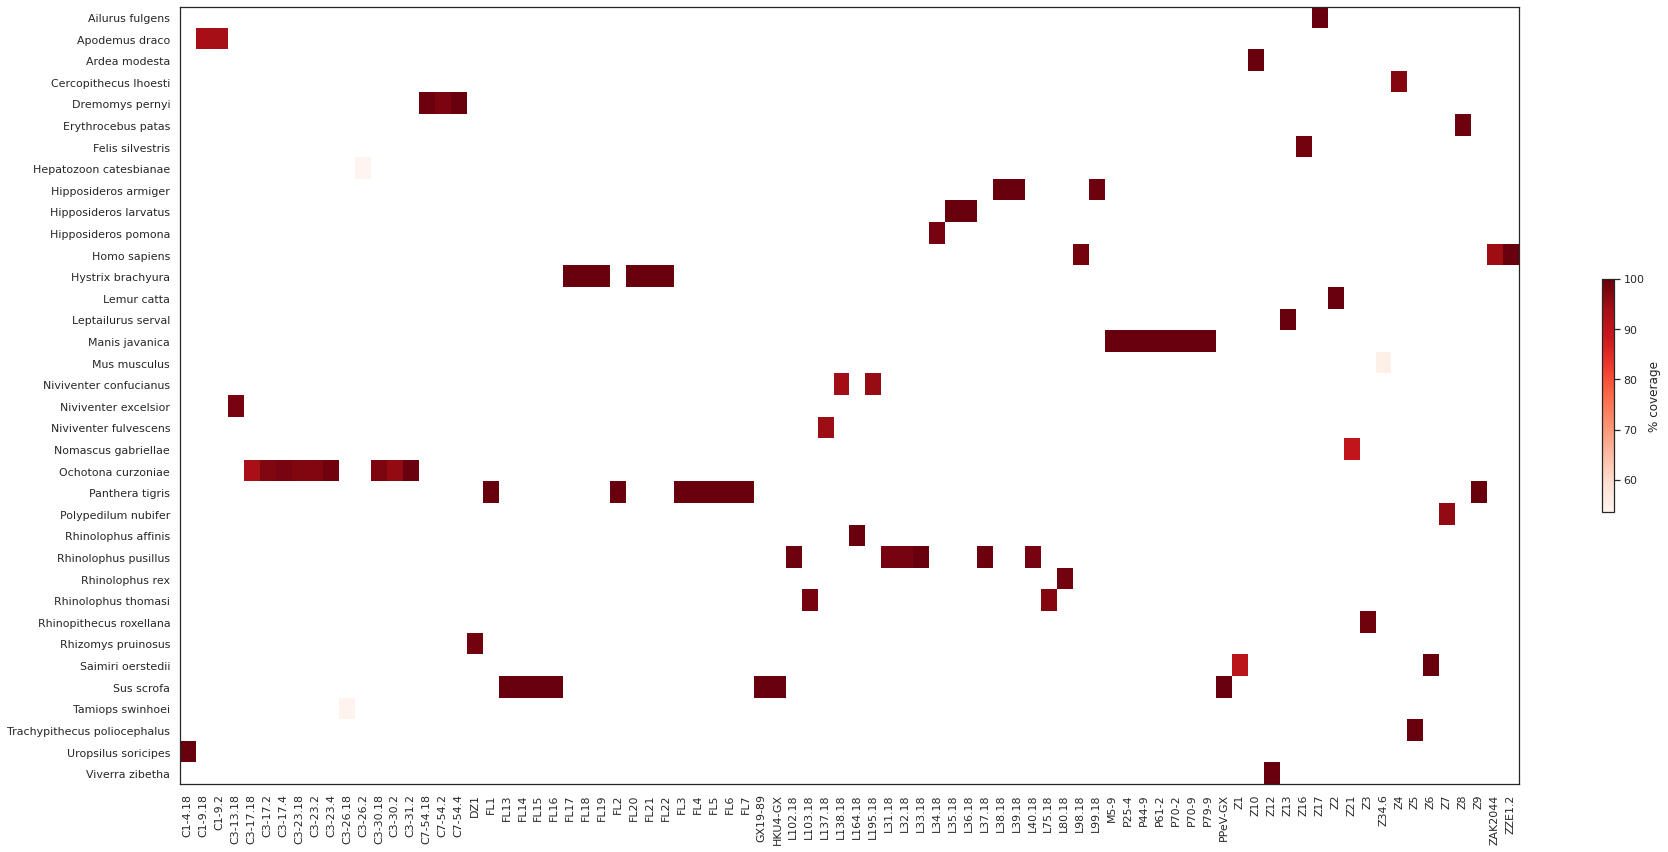

In [302]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(26,12))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto',norm=matplotlib.colors.LogNorm())
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto')

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)

cbar=fig.colorbar(img, label='% coverage', shrink=0.3)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_sample_name_{COVERAGE}pct.png", bbox_inches='tight')

### Subset

In [237]:
sra_subset=['SRR22936419',
 'SRR22936420',
 'SRR22936421',
 'SRR22936497',
 'SRR22936765',
 'SRR22936770',
 'SRR22936771',
 'SRR22936772',
 'SRR22936773',
 'SRR22936754',
 'SRR22936759',
 'SRR22936582',
 'SRR22936583']

In [238]:
subset=['PPeV-GX', 'HKU4-GX', 'P79-9', 'DZ1', 'GX19-89', 'FL20', 'FL16', 'FL15', 'FL14', 'FL13', 'Z8', 'Z4', 'L99.18', 'L98.18', 'P70-9', 'P79-9', 'ZZE1.2']

In [239]:
df_pivot.index

Index(['C1-4.18', 'C1-9.18', 'C1-9.2', 'C3-13.18', 'C3-17.18', 'C3-17.2',
       'C3-17.4', 'C3-23.18', 'C3-23.2', 'C3-23.4', 'C3-26.18', 'C3-26.2',
       'C3-30.18', 'C3-30.2', 'C3-31.2', 'C7-54.18', 'C7-54.2', 'C7-54.4',
       'DZ1', 'FL1', 'FL13', 'FL14', 'FL15', 'FL16', 'FL17', 'FL18', 'FL19',
       'FL2', 'FL20', 'FL21', 'FL22', 'FL3', 'FL4', 'FL5', 'FL6', 'FL7',
       'GX19-89', 'HKU4-GX', 'L102.18', 'L103.18', 'L137.18', 'L138.18',
       'L164.18', 'L195.18', 'L31.18', 'L32.18', 'L33.18', 'L34.18', 'L35.18',
       'L36.18', 'L37.18', 'L38.18', 'L39.18', 'L40.18', 'L75.18', 'L80.18',
       'L98.18', 'L99.18', 'M5-9', 'P25-4', 'P44-9', 'P61-2', 'P70-2', 'P70-9',
       'P79-9', 'PPeV-GX', 'Z1', 'Z10', 'Z12', 'Z13', 'Z16', 'Z17', 'Z2',
       'Z21', 'Z3', 'Z34.6', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'ZAK2044',
       'ZZE1.2'],
      dtype='object', name='sample_name')

In [240]:
df_pang_sus=df_pivot[df_pivot.index.isin(subset)]

In [241]:
df_pang_sus.head()

description,Ailurus fulgens,Apodemus draco,Ardea modesta,Cercopithecus lhoesti,Dremomys pernyi,Erythrocebus patas,Felis silvestris,Hepatozoon catesbianae,Hipposideros armiger,Hipposideros larvatus,...,Rhinolophus rex,Rhinolophus thomasi,Rhinopithecus roxellana,Rhizomys pruinosus,Saimiri oerstedii,Sus scrofa,Tamiops swinhoei,Trachypithecus poliocephalus,Uropsilus soricipes,Viverra zibetha
sample_name,,,,,,,,,,,,,,,,,,,,,
DZ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,98.7753,NaN,NaN,NaN,NaN,NaN,NaN
FL13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN
FL14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN
FL15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN
FL16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN


In [242]:
df_pang_sus=df_pang_sus.dropna(how='all', axis=1)

In [243]:
df_pang_sus.to_csv(PLOT_PATH+'subset_runs_no_null.csv')

In [246]:
df_pang_sus.head()

description,Cercopithecus lhoesti,Erythrocebus patas,Hipposideros armiger,Homo sapiens,Hystrix brachyura,Manis javanica,Rhizomys pruinosus,Sus scrofa
sample_name,,,,,,,,
DZ1,NaN,NaN,NaN,NaN,NaN,NaN,98.7753,NaN
FL13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
FL14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
FL15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
FL16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [247]:
df_pang_sus=df_pang_sus.T

In [248]:
data=df_pang_sus.to_numpy()

y_labels=df_pang_sus.index.tolist()
x_labels=list(df_pang_sus.columns.values)
y_names=y_labels
x_codes=x_labels
plot_data = np.ma.masked_equal(data[:,:], 0)

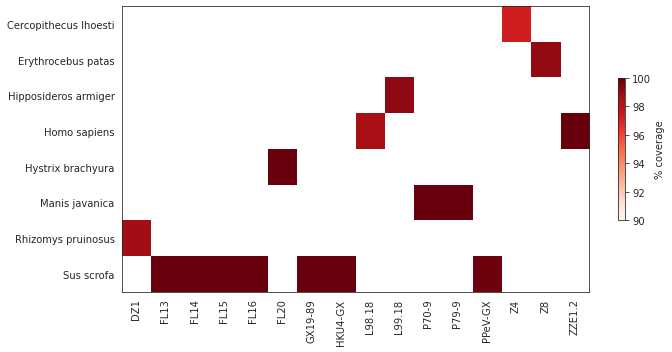

In [249]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,5))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto',norm=matplotlib.colors.LogNorm())
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto', vmin = 90, vmax = 100)

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)

cbar=fig.colorbar(img, label='% coverage', shrink=0.5)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_sample_name_pangolin_sus_N_{COVERAGE}pct_v2.png", bbox_inches='tight')

## Percent


In [250]:
### filter to => N%
df_frac = df_all.loc[df_all['coverage'] >=COVERAGE]

In [251]:
COVERAGE

50

In [252]:
total_mt_count = df_all['mt_reads'].sum()
df_frac['total_cut_mt_reads'] = total_mt_count
df_frac['cut_frac_mt'] = df_frac['mt_reads'].div(total_mt_count).round(4)
df_frac['cut_frac_pct'] = df_frac['cut_frac_mt']*100

In [253]:
total_mt_count

175311243

In [254]:
df_frac.description=df_frac.description.str.replace(' mitochondrion, complete genome', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete genome', '')

In [255]:
#df_frac=df_frac.pivot_table(index='sample_name', columns='description', values='cut_frac_pct')
#df_frac.shape

In [256]:
df_frac=df_frac.pivot_table(index='sample_name', columns='description', values='pct_mt')
df_frac.shape

(84, 36)

In [257]:
df_frac_pang_sus=df_frac[df_frac.index.isin(subset)]

In [258]:
df_frac_pang_sus=df_frac_pang_sus.dropna(how='all', axis=1)

In [259]:
df_frac_pang_sus=df_frac_pang_sus.T

In [260]:
data=df_pang_sus.to_numpy()

y_labels=df_pang_sus.index.tolist()
x_labels=list(df_pang_sus.columns.values)
y_names=y_labels
x_codes=x_labels
plot_data = np.ma.masked_equal(data[:,:], 0)

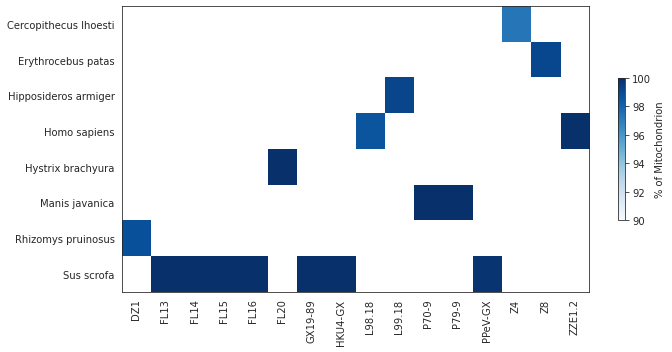

In [261]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,5))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto', \
#              norm=matplotlib.colors.LogNorm(), vmin = 10, vmax = 100)
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto', vmin = 90, vmax = 100)

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)


cbar=fig.colorbar(img, label='% of Mitochondrion', shrink=0.5)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_fraction_of_Mt_{COVERAGE}_log_V2.png", bbox_inches='tight')

## Mt to CoV ratios

NB HKU4-GX is here too optimistic, only 35 reads are likely to be valid Manis Mt genome alignments

In [262]:
df_cov=pd.read_csv(PLOT_PATH+'CoV_Alignments.csv')

In [263]:
df_cov['ratio']=df_cov["Mt to CoV ratio"].round(2)
df_cov['CoV reads']=df_cov["Total HKU4r (MjHKU4-CoV-1+P251T)"]
df_cov['MJ Mt reads']=df_cov["MJ Mt"]
df_cov.head()

,CoV,SRA,HKU4-GX,MjHKU4-CoV-1,MjHKU4-CoV-2,MjHKU4-CoV-3,MjHKU4-CoV-4,OM009282r,HKU4-BGI-2020,MT121216.1,Total HKU4r (MjHKU4-CoV-1+P251T),MJ Mt,Mt to CoV ratio,CoV.1,ratio,CoV reads,MJ Mt reads
0,HKU4-GX,SRR229366420,14404.0,14370.0,NaN,NaN,NaN,NaN,NaN,NaN,14370,338,0.023466,HKU4-GX (pending),0.02,14370,338
1,MjHKU4-CoV-4,CRR477157,NaN,64506.0,NaN,NaN,NaN,NaN,NaN,NaN,64506,27114,0.420333,MjHKU4-CoV-1+P251T,0.42,64506,27114
2,MjHKU4-CoV-3,CRR477156,NaN,701.0,NaN,NaN,NaN,NaN,NaN,NaN,701,100093,142.786020,MjHKU4-CoV-1+P251T,142.79,701,100093
3,MjHKU4-CoV-2,CRR477155,NaN,10062.0,NaN,NaN,NaN,NaN,NaN,NaN,10062,129926,12.912542,MjHKU4-CoV-1+P251T,12.91,10062,129926
4,MjHKU4-CoV-1,CRR477154,NaN,2538.0,NaN,NaN,NaN,NaN,NaN,NaN,2538,259819,102.371552,MjHKU4-CoV-1+P251T,102.37,2538,259819


In [264]:
#df_cov.drop(df_cov.tail(1).index,inplace=True)


In [265]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.set_style("whitegrid")

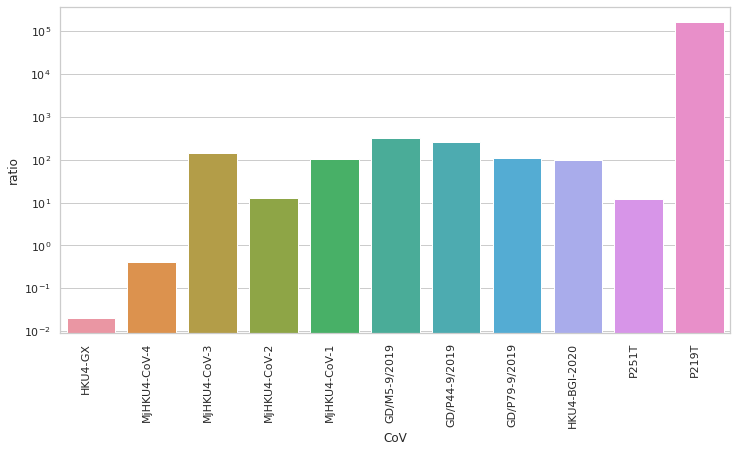

In [266]:
plt.yscale('log')
#,  palette=sns.color_palette("BuGn_r", n_colors=len(df_cov))
chart=sns.barplot(data=df_cov, x="CoV", y="ratio")

chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

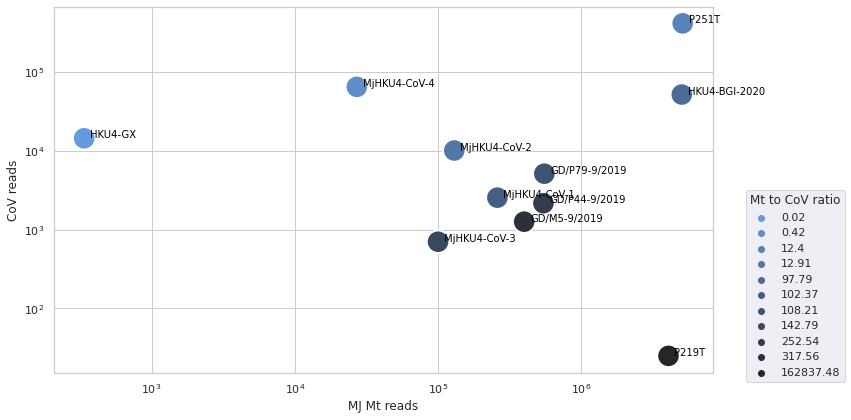

In [267]:
sns.axes_style("whitegrid")
scatter=sns.scatterplot(data=df_cov, x="MJ Mt reads", y="CoV reads", hue='ratio', s=500, palette=sns.dark_palette("#69d", reverse=True, n_colors=len(df_cov)))
sns.set(rc={"figure.figsize":(8, 6)})

plt.xscale('log')
plt.yscale('log')
#scatter.set(ylim=(1, None))
#scatter.set(xlim=(1, None))
for i in range(df_cov.shape[0]):
    plt.text(x=df_cov["MJ Mt reads"][i]+df_cov["MJ Mt reads"][i]*.1,y=df_cov["CoV reads"][i]+df_cov["CoV reads"][i]*.01,s=df_cov.CoV[i], 
          fontdict=dict(color='black',size=10)) 
    #rotation=45,weight='bold', alpha=0.8 
plt.legend(title='Mt to CoV ratio', bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(PLOT_PATH+f"Mt_CoV_scatter.png", bbox_inches='tight')